In [3]:
import torch
import torch.nn as nn
import yaml
import sys

In [4]:
with open('./model_config.yml', 'r') as file:
    config = yaml.safe_load(file)
    decoder_config = config["Decoder"]
    prior_config = config["Prior"]
    clip_config = config["CLIP"]

In [5]:
sys.path.insert(0, 'clip')
from clip.model import CLIP

sys.path.insert(0, 'dalle2')
from prior import DiffusionPriorNetwork
from decoder import UNet, Decoder
from diffusion import Diffusion
from dalle2_model import DALLE2

In [6]:
# Define hyperparameters
T = decoder_config["diffusion_timesteps"]
BATCH_SIZE = decoder_config["batch_size"]
IMG_SIZE = config["img_size"]
EPOCHS = decoder_config["epochs"]
LR = decoder_config["lr"]
GRAD_CLIP = decoder_config["grad_clip"]
NULL_TEXT_EMB_RATE = decoder_config["null_text_emb_rate"]
NULL_CLIP_EMB_RATE = decoder_config["null_clip_emb_rate"]
GUIDANCE_SCALE = decoder_config["guidance_scale"]

# CLIP embedding dimension
CLIP_EMB_DIM = config["CLIP"]["embed_dim"]

# UNet
DOWN_CHANNELS = decoder_config["down_channels"]
TIME_EMB_DIM = decoder_config["time_emb_dim"]

# UNet Transformer
N_VOCAB = decoder_config["n_vocab"]
CONTEXT_LENGTH = decoder_config["context_length"]
TRANSFORMER_WIDTH = decoder_config["transformer_width"]
TRANSFORMER_LAYERS = decoder_config["transformer_layers"]
TRANSFORMER_HEADS = decoder_config["transformer_heads"]

# UNet attention block
QKV_HEADS = decoder_config["qkv_heads"]


# Create diffusion
decoder_diffusion = Diffusion(T)

# Create UNet
unet = UNet(
    down_channels=DOWN_CHANNELS,
    time_emb_dim=TIME_EMB_DIM,
    n_vocab=N_VOCAB,
    context_length=CONTEXT_LENGTH,
    transformer_width=TRANSFORMER_WIDTH,
    transformer_layers=TRANSFORMER_LAYERS,
    transformer_heads=TRANSFORMER_HEADS,
    qkv_heads=QKV_HEADS,
    clip_emb_dim=CLIP_EMB_DIM
)
unet.load_state_dict(torch.load("./models/decoder1.pth"))

# Create decoder
decoder = Decoder(unet, num_timesteps=T)

In [7]:
T = prior_config["diffusion_timesteps"]
BATCH_SIZE = prior_config["batch_size"]
IMG_SIZE = config["img_size"]
EPOCHS = prior_config["epochs"]
LR = prior_config["lr"]
CONTEXT_LENGTH = prior_config["context_length"]

prior_diffusion = Diffusion(T)

# Create Prior
prior = DiffusionPriorNetwork(
    dim=config["CLIP"]["embed_dim"],
    num_timesteps=T,
    max_text_len=CONTEXT_LENGTH,
    depth=prior_config["depth"],
    dim_head=prior_config["dim_per_head"],
    heads=prior_config["heads"],
    ff_mult=prior_config["ff_mult"],
)

prior.load_state_dict(torch.load(prior_config["model_path"]))


<All keys matched successfully>

In [8]:
clip = CLIP(
    embed_dim=clip_config["embed_dim"],
    image_resolution=IMG_SIZE,
    vision_layers=clip_config["vision_layers"],
    vision_width=clip_config["vision_width"],
    vision_patch_size=clip_config["vision_patch_size"],
    context_length=clip_config["context_length"],
    vocab_size=clip_config["vocab_size"],
    transformer_width=clip_config["transformer_width"],
    transformer_heads=clip_config["transformer_heads"],
    transformer_layers=clip_config["transformer_layers"]
)
clip.load_state_dict(torch.load(clip_config["model_path"]))

<All keys matched successfully>

In [58]:
dalle2 = DALLE2(clip, prior, decoder)
dalle2.val_mode()


In [10]:
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

IMG_DIM = (3, IMG_SIZE, IMG_SIZE)

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

dalle2 = dalle2.to(device=device)

cuda


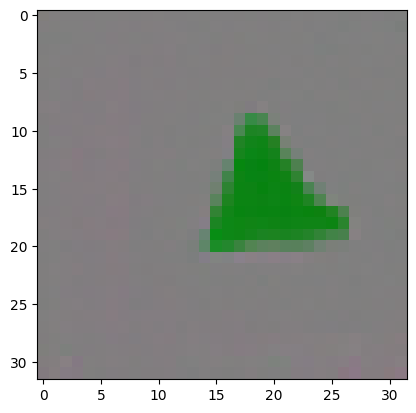

In [19]:
dalle2.train()
image = dalle2((3, IMG_SIZE, IMG_SIZE), "a green triangle", prior_diffusion, decoder_diffusion, cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())

In [79]:
sys.path.insert(0, 'dataset')
from dataset import load_data
from torch.utils.data import DataLoader

train_data, _ = load_data(root_dir="./data2", img_size=IMG_SIZE)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Dataset size: 15000
Dataset size: 2000


In [68]:
img, txt = next(iter(dataloader))

NameError: name 'dataloader' is not defined

In [17]:
idx = 3
image = img[None, idx]
text = txt[idx]

print(text)

a black rectangle


In [48]:
sys.path.insert(0, 'nn_components')
from tokenizer import tokenize

text_tokens = tokenize(text, context_length=dalle2.clip.context_length)
text_tokens = text_tokens.to(device=dalle2.device)
text_embedding = dalle2.clip.encode_text(text_tokens, normalize=True)
image_embedding = dalle2.prior.sample(prior_diffusion, text_embedding, text_encodings=text_tokens)

In [49]:
image_embedding_truth = dalle2.clip.encode_image(image.to(device=dalle2.device), normalize=True)

print(image_embedding)
print(image_embedding_truth)

tensor([[ 0.4166, -0.0312,  0.3619,  0.0209, -0.4754,  0.5349]],
       device='cuda:0')
tensor([[ 0.2169, -0.0241,  0.4038, -0.3160, -0.6890,  0.4634]],
       device='cuda:0')


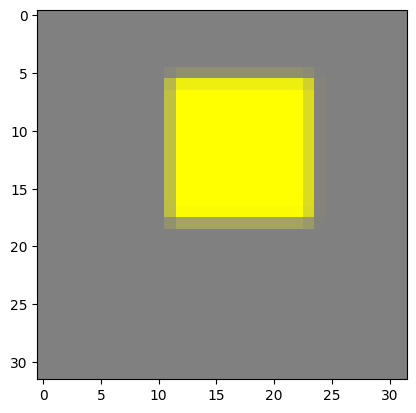

In [50]:
show_tensor_image(image)

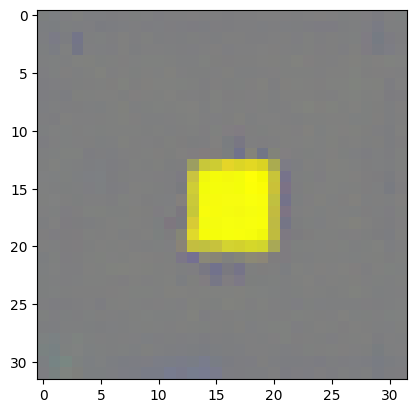

In [51]:
decoder = decoder.train()
img_pred = decoder.sample_one(IMG_DIM, text_tokens, clip_emb=image_embedding,diffusion=decoder_diffusion,cf_guidance_scale=2)
show_tensor_image(img_pred.detach().cpu())

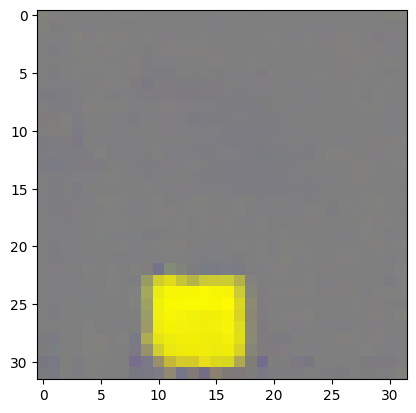

In [52]:
img_pred = decoder.sample_one(IMG_DIM, text_tokens, clip_emb=image_embedding_truth,diffusion=decoder_diffusion,cf_guidance_scale=2)
show_tensor_image(img_pred.detach().cpu())

In [31]:
@torch.no_grad()
def sample_plot_image(decoder: Decoder, tokens, clip_emb, diffusion: Diffusion, guidance_scale=GUIDANCE_SCALE, **kwargs):
    # model.eval()
    assert tokens.shape == (1, CONTEXT_LENGTH)
    # Sample noise
    img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
    fig = plt.figure(figsize=(15,6))
    plt.axis('off')

    num_images = 10
    stepsize = int(T/num_images)

    title = kwargs["caption"]
    assert clip_emb.shape == (1, CLIP_EMB_DIM)

    plt.title(title)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = decoder.sample_timestep(img, t, tokens, clip_emb, diffusion, cf_guidance_scale=guidance_scale)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            fig.add_subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

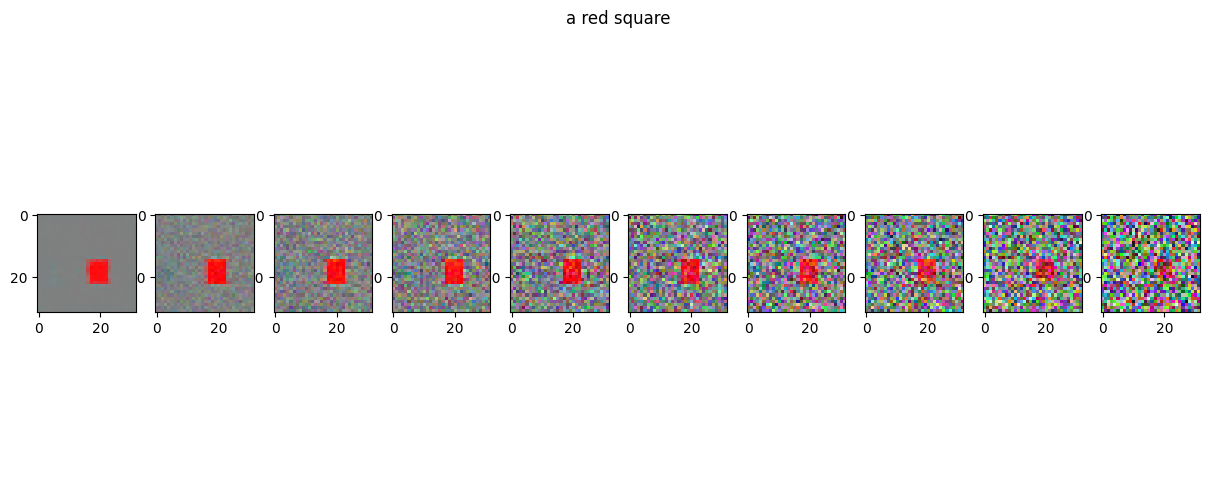

In [38]:
sample_plot_image(decoder, text_tokens, image_embedding_truth, decoder_diffusion, guidance_scale=2, caption=text)

In [80]:
from sklearn.neighbors import NearestNeighbors

def knn(x, xs, k=5, metric="euclidean"):
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(xs)
    distances, indices = nbrs.kneighbors(x)
    return distances, indices

In [81]:
import tqdm

image_embeddings = []
with torch.no_grad():
    for step, (img, txt) in enumerate(dataloader):
        img = img.to(device=dalle2.device)
        img_emb = dalle2.clip.encode_image(img, normalize=True)
        image_embeddings.append(img_emb.detach().cpu().numpy())

In [82]:
from functools import reduce

image_embeddings = reduce(lambda x, y: np.concatenate((x, y)), image_embeddings)

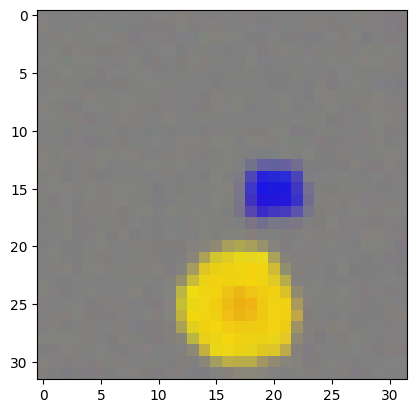

In [109]:
image = dalle2((3, IMG_SIZE, IMG_SIZE), "a large gold pentagon", prior_diffusion, decoder_diffusion, cf_guidance_scale=2)
show_tensor_image(image.detach().cpu())

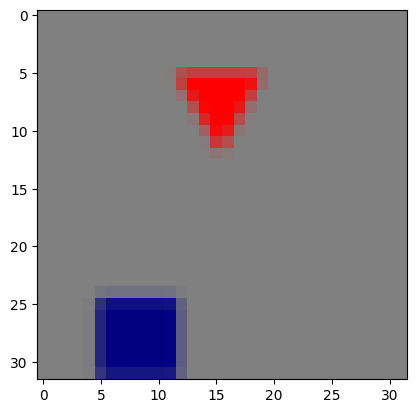

In [90]:
image = train_data[13542][0][None, :, :, :]
show_tensor_image(image)

7047


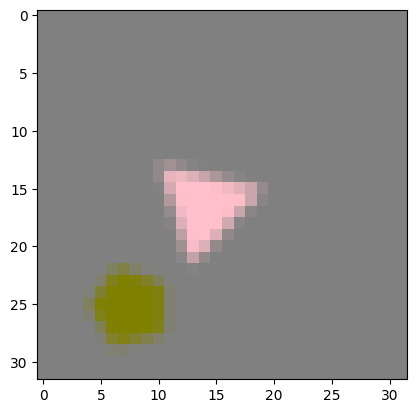

10497


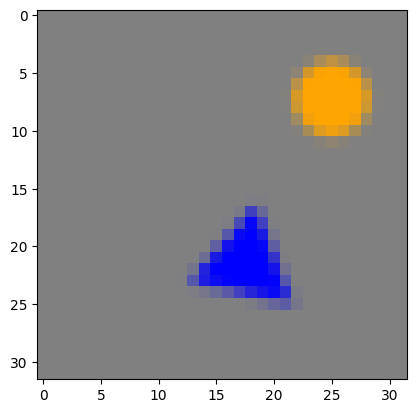

11803


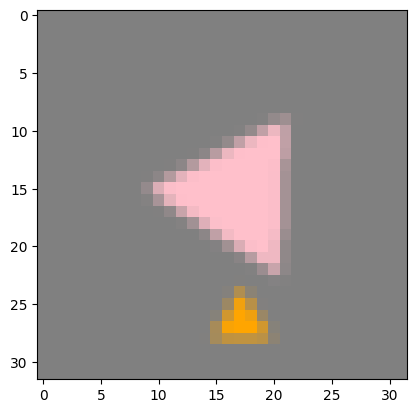

14360


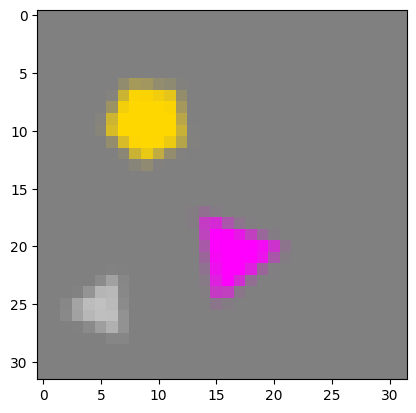

11073


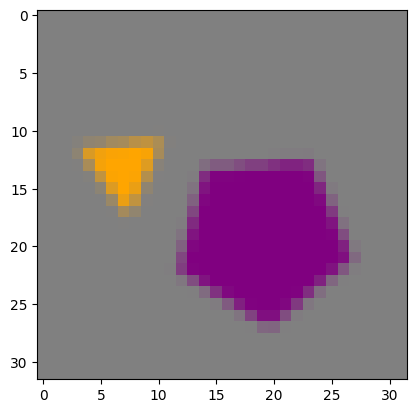

In [110]:
image_embedding = dalle2.clip.encode_image(image.to(device=dalle2.device), normalize=True)
image_embedding = image_embedding.detach().cpu().numpy()
_, indices = knn(image_embedding, image_embeddings, k=5, metric="euclidean")
for i in indices[0]:
    print(i)
    show_tensor_image(train_data[i][0])
    plt.show()

In [78]:
print(image_embedding)
print(image_embeddings[indices[0][0]])

[[-0.63045883  0.6981799  -0.18630196 -0.1732569  -0.10540351  0.19806628]]
[-0.4420597   0.70113516 -0.06100966 -0.45924625 -0.15751079  0.27120802]
